In [ ]:
!pip3 install -q -U bitsandbytes transformers peft accelerate datasets scipy einops evaluate trl rouge_score

In [ ]:
!pip3 install pandas matplotlib 

In [ ]:
!pip3 install tf-keras==2.16.0

In [ ]:
!pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu121

In [ ]:
!pip3 install pynvml gradio

In [ ]:
!pip3 install SentencePiece

In [ ]:
import nltk
nltk.data.path.append('../nltk_data')
nltk.download('punkt_tab')
nltk.download("punkt")

In [1]:
# Import the necessary libraries
import nltk
from datasets import load_dataset
import evaluate
import numpy as np
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

/common/home/projectgrps/CS425/CS425G12/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-13 17:04:28.596807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 17:04:28.622648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 17:04:28.622714: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 17:04:28.640889: I tensorflow/core/platform/cpu_fea

In [2]:
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [3]:
print_gpu_utilization()

GPU memory occupied: 1788 MB.


In [4]:
import pandas as pd
train = pd.read_csv("train_data_cleaned.csv")
val = pd.read_csv("validation_data_cleaned.csv")

In [5]:
train = train.iloc[0:3000].copy()
val = val.iloc[0:300].copy()

In [6]:
print(train)

                                         short_question  \
0     can an antibiotic through an iv give you a ras...   
1     can you test positive from having the hep b va...   
2     what are the dietary restrictions for celiac d...   
3     i have had a pneumonia shot can i get either a...   
4     my baby ate her on poop my baby ate poop 4 day...   
...                                                 ...   
2995  is inhaling clorox dangerous if you had a pneu...   
2996  what treatment is suggested for non dysplasia ...   
2997               what are the risks of genital herpes   
2998  my periods have always been weird – never norm...   
2999  what can cause prolonged male discharge  my hu...   

                                           short_answer  \
0     yes it can even after you have finished the pr...   
1     test positive for what if you had a hep b vacc...   
2     omitting gluten from the diet is the key to co...   
3     you can always catch an illness from a child b...

In [7]:
from datasets import load_dataset
from datasets import Dataset
train = Dataset.from_pandas(train)
train

Dataset({
    features: ['short_question', 'short_answer', 'tags', 'label'],
    num_rows: 3000
})

In [8]:
val = Dataset.from_pandas(val)
val

Dataset({
    features: ['short_question', 'short_answer', 'tags', 'label'],
    num_rows: 300
})

In [9]:
# Load the tokenizer, model, and data collator
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-base")
model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-base")
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [10]:
def print_number_of_trainable_model_parameters(model_name):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 222903552
all model parameters: 222903552
percentage of trainable model parameters: 100.00%


In [11]:
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [12]:
# We prefix our tasks with "answer the question"
prefix = "answer the medical question: "

# Define our preprocessing function
def preprocess_function(examples):
    """Add prefix to the sentences, tokenize the text, and set the labels"""
    # The "inputs" are the tokenized answer:
     # Drop unnecessary columns
    examples.pop('tags', None)  # Remove 'tags' column if it exists
    examples.pop('label', None)  # Remove 'label' column if it exists
    inputs = [prefix + doc for doc in examples["short_question"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding='max_length')
    
    # The "labels" are the tokenized outputs:
    labels = tokenizer(text_target=examples["short_answer"], max_length=512, truncation=True, padding='max_length')
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Map the preprocessing function across our dataset
tokenized_train = train.map(preprocess_function, batched=True)
tokenized_val = val.map(preprocess_function, batched=True)

Map: 100%|██████████| 300/300 [00:00<00:00, 1737.69 examples/s]


In [13]:
print(tokenized_train[0])

{'short_question': 'can an antibiotic through an iv give you a rash a couple days later', 'short_answer': 'yes it can even after you have finished the prescription for antibiotics', 'input_ids': [1525, 8, 1035, 822, 10, 54, 46, 14458, 190, 46, 3, 23, 208, 428, 25, 3, 9, 3, 12380, 3, 9, 1158, 477, 865, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [14]:
# Set up Rouge score for evaluation
nltk.data.path.append('../nltk_data')
nltk.download('punkt_tab')
nltk.download("punkt")
metric = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # decode preds and labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # rougeLSum expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return result

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /common/home/projectgrps/CS425/CS425G12/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /common/home/projectgrps/CS425/CS425G12/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
try:
    nltk.data.find('tokenizers/punkt')
    print("Punkt tokenizer is available.")
except LookupError:
    print("Punkt tokenizer is not available. You need to download it.")

Punkt tokenizer is available.


In [18]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# Set up training arguments with suggested changes
training_args = Seq2SeqTrainingArguments(
    output_dir="./31Oct_t5_base",
    evaluation_strategy="epoch",
    save_strategy="epoch",  # Set save strategy to match evaluation strategy
    learning_rate=2e-4,  # Adjusted learning rate
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,  # Increased evaluation batch size
    weight_decay=0.1,  # Slightly increased weight decay
    save_total_limit=3,
    num_train_epochs=10,  # Reduced number of epochs for monitoring
    predict_with_generate=True,
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model='eval_loss',  # Metric to monitor
    greater_is_better=False,  # False for loss
    push_to_hub=False
)

# Set up trainer with TensorBoard callback
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/common/home/projectgrps/CS425/CS425G12/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2570134/3017541016.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [19]:
# Train the model
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,0.692416,0.142256,0.025004,0.107564,0.107755
2,0.843300,0.672418,0.139995,0.024894,0.107018,0.107245
3,0.672400,0.664264,0.139207,0.026726,0.106676,0.106792
4,0.639300,0.661660,0.147559,0.029089,0.112074,0.111937
5,0.639300,0.661206,0.147592,0.028835,0.111169,0.110977
6,0.588000,0.663203,0.146694,0.028290,0.113950,0.113708
7,0.571100,0.665667,0.148186,0.029662,0.114419,0.114032
8,0.534500,0.668016,0.148571,0.031588,0.114867,0.114547
9,0.534500,0.671289,0.150346,0.031308,0.113242,0.112945
10,0.522000,0.672394,0.151662,0.031749,0.115946,0.115675


/common/home/projectgrps/CS425/CS425G12/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/common/home/projectgrps/CS425/CS425G12/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/common/home/projectgrps/CS425/CS425G12/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.


TrainOutput(global_step=3750, training_loss=0.6177615885416666, metrics={'train_runtime': 1568.0873, 'train_samples_per_second': 19.132, 'train_steps_per_second': 2.391, 'total_flos': 4567184179200000.0, 'train_loss': 0.6177615885416666, 'epoch': 10.0})

In [20]:
# Evaluate the best model on the validation dataset
eval_results = trainer.evaluate()

# Display evaluation results
print("Best Model Evaluation Results:", eval_results)

# Optionally save the best model
trainer.save_model("./best_model_t5_base")  # Use trainer's save_model method

/common/home/projectgrps/CS425/CS425G12/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Best Model Evaluation Results: {'eval_loss': 0.6612055897712708, 'eval_rouge1': 0.147592358390553, 'eval_rouge2': 0.028835230051705907, 'eval_rougeL': 0.11116924695849734, 'eval_rougeLsum': 0.11097735547559086, 'eval_runtime': 22.2115, 'eval_samples_per_second': 13.507, 'eval_steps_per_second': 1.711, 'epoch': 10.0}


# Plotting the graph

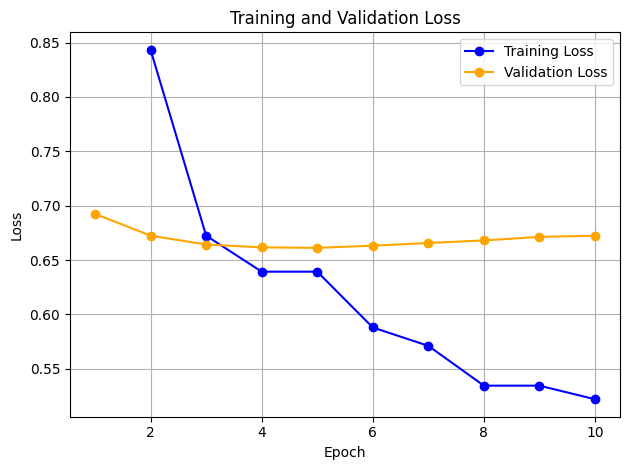

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the data
data = {
    'Epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Training Loss': [None, 0.843300, 0.672400, 0.639300, 0.639300, 0.588000, 0.571100, 0.534500, 0.534500, 0.522000],
    'Validation Loss': [0.692416, 0.672418, 0.664264, 0.661660, 0.661206, 0.663203, 0.665667, 0.668016, 0.671289, 0.672394],
    'Rouge1': [0.142256, 0.139995, 0.139207, 0.147559, 0.147592, 0.146694, 0.148186, 0.148571, 0.150346, 0.151662],
    'Rouge2': [0.025004, 0.024894, 0.026726, 0.029089, 0.028835, 0.028290, 0.029662, 0.031588, 0.031308, 0.031749],
    'Rougel': [0.107564, 0.107018, 0.106676, 0.112074, 0.111169, 0.113950, 0.114419, 0.114867, 0.113242, 0.115946],
    'Rougelsum': [0.107755, 0.107245, 0.106792, 0.111937, 0.110977, 0.113708, 0.114032, 0.114547, 0.112945, 0.115675]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plot Training and Validation Loss
plt.plot(df['Epoch'], df['Training Loss'], marker='o', label='Training Loss', color='blue')
plt.plot(df['Epoch'], df['Validation Loss'], marker='o', label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

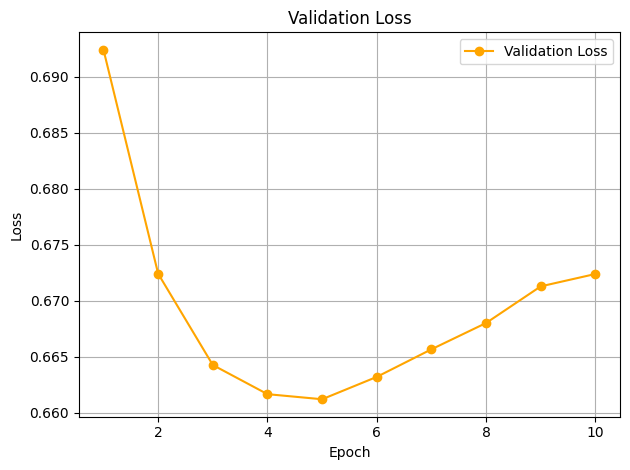

In [22]:
plt.plot(df['Epoch'], df['Validation Loss'], marker='o', label='Validation Loss', color='orange')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

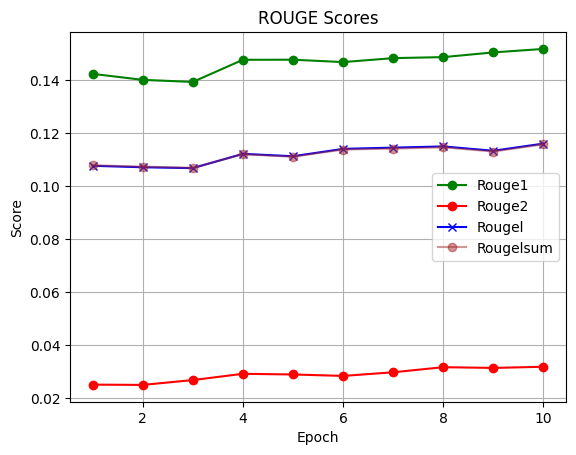

In [23]:
# Plot ROUGE Scores
plt.plot(df['Epoch'], df['Rouge1'], marker='o', label='Rouge1', color='green')
plt.plot(df['Epoch'], df['Rouge2'], marker='o', label='Rouge2', color='red')
plt.plot(df['Epoch'], df['Rougel'], marker='x', label='Rougel', color='blue')  # Dashed line with transparency
plt.plot(df['Epoch'], df['Rougelsum'], marker='o', label='Rougelsum', color='brown',alpha=0.5)  # Dotted line style
plt.title('ROUGE Scores')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid()

In [24]:
print_gpu_utilization()

GPU memory occupied: 14749 MB.


In [25]:
import torch
# Free memory for merging weights if needed
del model
torch.cuda.empty_cache()

In [26]:
print_gpu_utilization()

GPU memory occupied: 5427 MB.


# Evaluation

In [27]:
to_test = pd.read_csv("validation_data_cleaned.csv")
val_test = to_test.iloc[1:301].copy()

In [28]:
# Load models
original_model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-base")
fine_tuned_model = T5ForConditionalGeneration.from_pretrained("./best_model_t5_base")

# Load the tokenizer (same for both models)
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-base")

In [29]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import pandas as pd
import torch
from tqdm import tqdm  # Import tqdm for progress tracking


def generate_comparison_dataframe(original_model, fine_tuned_model, tokenizer):
    """
    Generates a DataFrame comparing human answers with model outputs.

    Args:
        train: DataFrame containing short questions and answers.
        original_model: The pre-trained model (original).
        fine_tuned_model: The fine-tuned model.
        tokenizer: The tokenizer used for both models.

    Returns:
        comparison_df: DataFrame containing questions, human answers, original and fine-tuned model outputs.
    """
    # Ensure both models are in evaluation mode
    original_model.eval()
    fine_tuned_model.eval()

    # Initialize lists to hold the results
    questions = []
    human_answers = []
    original_answers = []
    fine_tuned_answers = []

    # Generate predictions for each question in the train DataFrame
    with torch.no_grad():
        for index, row in tqdm(val_test.iterrows(), total=val_test.shape[0], desc="Generating Outputs"):
            question = "answer the medical question: " + row['short_question']
            human_answer = row['short_answer']

            # Tokenize the input question
            input_ids = tokenizer(question, return_tensors="pt", padding=True, truncation=True).input_ids
            
           # Generate answers from the original model
            original_outputs = original_model.generate(input_ids, max_length=128)  # Specify max_length here
            original_output_text = tokenizer.decode(original_outputs[0], skip_special_tokens=True)
            
            # Generate answers from the fine-tuned model
            fine_tuned_outputs = fine_tuned_model.generate(input_ids, max_length=128, no_repeat_ngram_size=3,top_k=50, top_p=0.95)
            fine_tuned_output_text = tokenizer.decode(fine_tuned_outputs[0], skip_special_tokens=True)

            # Append results to the lists
            questions.append(question)
            human_answers.append(human_answer)
            original_answers.append(original_output_text)
            fine_tuned_answers.append(fine_tuned_output_text)

    # Create a DataFrame to compare the results
    comparison_another_df = pd.DataFrame({
        'Question': questions,
        'Human Answer': human_answers,
        'Original Model Answer': original_answers,
        'Fine-tuned Model Answer': fine_tuned_answers
    })

    return comparison_another_df

# Example usage
comparison_another_df = generate_comparison_dataframe(original_model, fine_tuned_model, tokenizer)

# Display the DataFrame
comparison_another_df


Generating Outputs:   0%|          | 0/300 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/common/home/projectgrps/CS425/CS425G12/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Generating Outputs: 100%|██████████| 300/300 [17:47<00:00,  3.56s/it]


,Question,Human Answer,Original Model Answer,Fine-tuned Model Answer
0,answer the medical question: i need to buy hea...,go to healthcare gov call my husband 407 222 9...,True,you can find information about health insuranc...
1,answer the medical question: i had an acute eb...,hi yes a chronic ebv infection also can be rul...,True,hi if you have a ebv antibody test then you sh...
2,answer the medical question: i am 19 and have ...,it seems more of anxiety exercises yoga medita...,True,hi if you have any symptoms then you need to s...
3,answer the medical question: hockey player has...,synovitis and cartilage damage seems to have o...,True,i am sorry to hear you are going through this ...
4,answer the medical question: is dust a cause o...,dust can be contaminated with staph bacteria o...,True,dust is not a cause of staph infection but it ...
...,...,...,...,...
295,answer the medical question: i have ulcerative...,hi read this link its very informative about y...,True,i am sorry to hear you are going through this ...
296,answer the medical question: i am having probl...,are the findings that you have quoted your imp...,True,hi i am sorry to hear you are going through th...
297,answer the medical question: how do i eat righ...,for the best fitness results it is important t...,True,eat right eat well and exercise regularly to g...
298,answer the medical question: is b12 effective ...,b12 does have some beneficial effect with shin...,True,b12 is a vitamin that is used to treat shingle...


In [30]:
comparison_another_df.to_excel('T5Base_final_result.xlsx',index=False)

In [31]:
comparison_another_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Question                 300 non-null    object
 1   Human Answer             300 non-null    object
 2   Original Model Answer    300 non-null    object
 3   Fine-tuned Model Answer  300 non-null    object
dtypes: object(4)
memory usage: 9.5+ KB


In [32]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd
import torch

# Function to calculate ROUGE scores
def calculate_rouge_scores(human_answers, model_answers):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rouge_sum': 0.0}
    
    for human, model in zip(human_answers, model_answers):
        scores = scorer.score(human, model)
        rouge_scores['rouge1'] += scores['rouge1'].fmeasure
        rouge_scores['rouge2'] += scores['rouge2'].fmeasure
        rouge_scores['rougeL'] += scores['rougeL'].fmeasure
    
    # Average the scores
    total_samples = len(human_answers)
    if total_samples > 0:
        for metric in rouge_scores:
            rouge_scores[metric] /= total_samples
            
        # Calculate ROUGE sum
        rouge_scores['rouge_sum'] = (rouge_scores['rouge1'] + 
                                      rouge_scores['rouge2'] + 
                                      rouge_scores['rougeL']) / 3  # Average of the ROUGE scores

    return rouge_scores

# Function to calculate BLEU score
def calculate_bleu_scores(human_answers, model_answers):
    chencherry = SmoothingFunction()
    bleu_score_total = 0.0
    
    for human, model in zip(human_answers, model_answers):
        reference = [human.split()]  # Reference needs to be a list of lists of tokens
        candidate = model.split()    # Candidate is a single list of tokens
        bleu_score_total += sentence_bleu(reference, candidate, smoothing_function=chencherry.method1)
    
    # Calculate average BLEU score
    total_samples = len(human_answers)
    average_bleu = bleu_score_total / total_samples if total_samples > 0 else 0.0

    return average_bleu

# Function to calculate ROUGE and BLEU improvement
def calculate_improvement(original_scores, fine_tuned_scores):
    improvement = {}
    
    for metric in original_scores.keys():  # Include 'rouge1', 'rouge2', 'rougeL', 'rouge_sum', 'bleu'
        original_score = original_scores[metric]
        fine_tuned_score = fine_tuned_scores[metric]
        
        if original_score == 0:
            if fine_tuned_score > 0:
                improvement[metric] = float('inf')  # Infinite improvement if the original score is zero
            else:
                improvement[metric] = 0.0
        else:
            improvement[metric] = ((fine_tuned_score - original_score) / abs(original_score)) * 100

    return improvement

# Assuming comparison_df is already created and populated with the necessary data
if 'comparison_another_df' in locals():
    # Extract human answers and model answers from the DataFrame
    human_answers = comparison_another_df['Human Answer'].tolist()
    original_answers = comparison_another_df['Original Model Answer'].tolist()
    fine_tuned_answers = comparison_another_df['Fine-tuned Model Answer'].tolist()

    # Calculate ROUGE scores for both models
    original_rouge_scores = calculate_rouge_scores(human_answers, original_answers)
    fine_tuned_rouge_scores = calculate_rouge_scores(human_answers, fine_tuned_answers)
    
    # Calculate BLEU scores for both models
    original_bleu_score = calculate_bleu_scores(human_answers, original_answers)
    fine_tuned_bleu_score = calculate_bleu_scores(human_answers, fine_tuned_answers)

    # Combine scores for improvement calculation
    original_scores = {**original_rouge_scores, 'bleu': original_bleu_score}
    fine_tuned_scores = {**fine_tuned_rouge_scores, 'bleu': fine_tuned_bleu_score}

    # Calculate improvement
    improvement = calculate_improvement(original_scores, fine_tuned_scores)

    # Display results with formatting
    print("Original ROUGE and BLEU Scores:")
    for key, value in original_scores.items():
        print(f"  {key}: {value:.4f}")

    print("\nFine-tuned ROUGE and BLEU Scores:")
    for key, value in fine_tuned_scores.items():
        print(f"  {key}: {value:.4f}")

    print("\nROUGE and BLEU Improvement:")
    for key, value in improvement.items():
        print(f"  {key}: {value:.2f}%")
else:
    print("Error: comparison_another_df is not defined.")


Original ROUGE and BLEU Scores:
  rouge1: 0.0010
  rouge2: 0.0001
  rougeL: 0.0010
  rouge_sum: 0.0007
  bleu: 0.0000

Fine-tuned ROUGE and BLEU Scores:
  rouge1: 0.2296
  rouge2: 0.0464
  rougeL: 0.1466
  rouge_sum: 0.1408
  bleu: 0.0175

ROUGE and BLEU Improvement:
  rouge1: 22696.74%
  rouge2: 61615.55%
  rougeL: 15309.59%
  rouge_sum: 20679.11%
  bleu: 80473.13%


# For Demo

### Run if need to load the model

In [1]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load models
original_model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-base")
fine_tuned_model = T5ForConditionalGeneration.from_pretrained("./best_model_t5_base")

# Load the tokenizer (same for both models)
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-base")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

C:\anaconda3\envs\py39\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Valentino Ong\.cache\huggingface\hub\models--google-t5--t5-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [35]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import pandas as pd
import torch
from tqdm import tqdm  # Import tqdm for progress tracking


def generate_comparison(question):
    """
    Given an input from user, generate the output from both original and fine tuned model

    Args:
        original_model: The pre-trained model (original).
        fine_tuned_model: The fine-tuned model.
        tokenizer: The tokenizer used for both models.

    Returns:
        comparison_df: DataFrame containing questions, human answers, original and fine-tuned model outputs.
    """
    # Ensure both models are in evaluation mode
    original_model.eval()
    fine_tuned_model.eval()

    # Generate predictions for each question in the train DataFrame
    with torch.no_grad():

        # Tokenize the input question
        input_ids = tokenizer(question, return_tensors="pt", padding=True, truncation=True).input_ids
        
       # Generate answers from the original model
        original_outputs = original_model.generate(input_ids,max_length=128)  # Specify max_length here
        original_output_text = tokenizer.decode(original_outputs[0], skip_special_tokens=True)
        
        # Generate answers from the fine-tuned model
        fine_tuned_outputs = fine_tuned_model.generate(input_ids, max_length=128, no_repeat_ngram_size=3,top_k=50, top_p=0.95)
        fine_tuned_output_text = tokenizer.decode(fine_tuned_outputs[0], skip_special_tokens=True)


    # Display results with formatting
    print("----------------------------------------------------------------------")
    print("Questions:")
    print(question)
    print("----------------------------------------------------------------------")
    print("Original Model Output:")
    print(original_output_text)
    print("----------------------------------------------------------------------")
    print("Fine-tuned Model Output:")
    print(fine_tuned_output_text)
    print("----------------------------------------------------------------------")
        

formatted = "answer the medical question: "
# question = "is there a generic form of plavix if not what is clopidogrel"
# question = "i use xonepex in my nebulizer for my emphysema could i use a watered down solution of vicks vapor steam in my nebulizer what would be the side effects in doing this it would be a mild solution and not a replacement for my xonepex i also use a cpap to sleep with at night could i put a drop of vicks vapor steam in my water tank to breath in instead of just plain water"
# question = "what is migraine without aura"
# question = "can you be allergic to mold in your food"
# question = "what is a seizure and what is epilepsy"
question = "what are the symptoms of gallstones"
generate_comparison(formatted + question)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/common/home/projectgrps/CS425/CS425G12/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


----------------------------------------------------------------------
Questions:
answer the medical question: what are the symptoms of gallstones
----------------------------------------------------------------------
Original Model Output:
True
----------------------------------------------------------------------
Fine-tuned Model Output:
symptoms of gallstones include a rash a fever and a lack of appetite gallstone symptoms include swollen gallbladder and enlarged gallblades gallstone is a condition that causes the body to produce more cholesterol than normal gallstone can cause a person to have enlarged or enlarged bile ducts gallstone may be a sign of a disease called biliary edema gallstone bilitus gallstone gallstone causes a rapid increase in blood pressure and billitus gallbladium gallstone disease gallstone fever is
----------------------------------------------------------------------


# Deploy to Gradio

In [72]:
# !pip3 install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 187.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 151.5 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [74]:
import gradio as gr
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

# Load your fine-tuned T5 model and tokenizer
model_name = "./best_model"
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Define a function to generate an answer
def generate_answer(question):
    # Tokenize the input question
    inputs = tokenizer.encode("answer the medical question: " + question, return_tensors="pt", truncation=True)
    
    # Generate the answer with the model
    outputs = model.generate(inputs, max_length=128, no_repeat_ngram_size=3, top_k=50, top_p=0.95)
    
    # Decode the generated answer
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return answer

# Set up the Gradio interface with proper input and output elements
iface = gr.Interface(
    fn=generate_answer,
    inputs=gr.inputs.Textbox(lines=2, placeholder="Enter your medical question here...", label="Question"),
    outputs=gr.outputs.Textbox(label="Answer"),
    title="Medical Question Answering Bot",
    description="Ask a medical question and get an answer generated by a fine-tuned model."
)

# Launch the Gradio app with share=True to get a public link
iface.launch(share=True)

which: no node in (/common/home/projectgrps/CS425/CS425G12/jupyterlab-venv-tf-217/bin:/opt/apps/software/CUDA/12.3.2/nvvm/bin:/opt/apps/software/CUDA/12.3.2/bin:/opt/apps/software/Python/3.11.7-GCCcore-11.2.0/bin:/opt/apps/software/OpenSSL/1.1/bin:/opt/apps/software/XZ/5.2.5-GCCcore-11.2.0/bin:/opt/apps/software/SQLite/3.36-GCCcore-11.2.0/bin:/opt/apps/software/Tcl/8.6.11-GCCcore-11.2.0/bin:/opt/apps/software/ncurses/6.2-GCCcore-11.2.0/bin:/opt/apps/software/bzip2/1.0.8-GCCcore-11.2.0/bin:/opt/apps/software/binutils/2.37-GCCcore-11.2.0/bin:/opt/apps/software/GCCcore/11.2.0/bin:/common/home/projectgrps/CS425/CS425G12/.local/bin:/common/home/projectgrps/CS425/CS425G12/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin)


* Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2024/10/31 22:59:32 [W] [service.go:132] login to server failed: session shutdown
